# GCP Data Manipulation

This notebook is dedicated to shifting data around my various GCP buckets.

I'd like the following my bucket:
* 1 folder with all the data (train/valid/test & val_test, a combination of valid + test)
* 1 folder with 10% of the data (train/test) - this should have the same distribution as the whole data

**Note:** I've combined the validation and test folders in `/val_test/`.

Mainly working with this resource: https://cloud.google.com/storage/docs/gsutil/commands/cp

In [3]:
import os
# Get all filepaths
train_imgs = os.listdir("train")
val_imgs = os.listdir("validation")
test_imgs = os.listdir("test")
train_imgs[:3], val_imgs[:3], test_imgs[:3]

(['0213d790e89c9f2a.jpg', 'ea585f0a157679db.jpg', '8f8c68e58073738a.jpg'],
 ['bfbb778f3fa6ed9d.jpg', '58f48187d94f8419.jpg', '6e2ea48a2474adf1.jpg'],
 ['784bcad5a8866352.jpg', '9cb18db470d1cce2.jpg', '9ee4d07829846ff3.jpg'])

In [4]:
len(train_imgs), len(val_imgs), len(test_imgs)

(34835, 859, 2112)

In [9]:
# Make folder which combines validation and test images (val images only have 800, test images only have 2000)
os.mkdir("val_test")
!cp -a validation/. val_test/
!cp -a test/. val_test/

In [12]:
# Check length of combined validation and test images
val_test_imgs = os.listdir("val_test")
print(len(val_test_imgs) == len(val_imgs + test_imgs))
len(val_test_imgs)

True


2971

In [13]:
# Use filepaths to move 10% of val_test and train (at random) into subset folders
os.mkdir("train_10")
os.mkdir("val_test_10")

In [18]:
from shutil import copy
import random

# Get random 10% of trian/val_test image paths
train_10_imgs = random.sample(train_imgs, len(train_imgs)//10)
val_test_10_imgs = random.sample(val_test_imgs, len(val_test_imgs)//10)
len(train_10_imgs), len(val_test_10_imgs)

(3483, 297)

In [20]:
# Move 10% of train images into their own folder
for img in train_10_imgs:
    #print(f"Copying: {img}")
    copy("train/"+img, "train_10")

Copying: 9569d683cf89eec8.jpg
Copying: da180caa6d3ab45d.jpg
Copying: 00b34adad08af621.jpg
Copying: 691ed71edf42bac9.jpg
Copying: ebfacf5c0540fe0d.jpg
Copying: 6722ccb5fdcfc9d3.jpg
Copying: 32b0b015cce46919.jpg
Copying: 79df4b882d93d8ea.jpg
Copying: a972894662afe15f.jpg
Copying: 406dcd912b5d8c38.jpg
Copying: 20e5fd490b22037a.jpg
Copying: 717892d78bedc353.jpg
Copying: 00a2ac8059da0512.jpg
Copying: 07209d0ef2ed0036.jpg
Copying: baa947b9a74a4e54.jpg
Copying: a1e49915f7589d55.jpg
Copying: 0dc18078bd60f908.jpg
Copying: 3d1371d65c8bdfe5.jpg
Copying: 09513f295141c57d.jpg
Copying: 32fb8f58b0ccaf27.jpg
Copying: 1c7ed47705414b74.jpg
Copying: d843b99e62bbe97a.jpg
Copying: 16d97933fd9c263c.jpg
Copying: 4d689cd1223905de.jpg
Copying: 5109259febd5b190.jpg
Copying: 0d845c70df06aad2.jpg
Copying: d854c136c5b982f5.jpg
Copying: 10db48798ec014c2.jpg
Copying: 43c822f0ab198276.jpg
Copying: ac380abb3290a7e2.jpg
Copying: 0d22ec4983f49930.jpg
Copying: 8469d0019bdaa5a5.jpg
Copying: b99fca80bc96c979.jpg
Copying: f

In [22]:
# Move 10% of val_test images into their own folder
for img in val_test_10_imgs:
    #print(f"Copying: {img}")
    copy("val_test/"+img, "val_test_10")

In [23]:
len(os.listdir("train_10")), len(os.listdir("val_test_10"))

(3483, 297)

In [32]:
# Check to see if train_10 matches the images in the folder
print(sorted(os.listdir("train_10")) == sorted(train_10_imgs))
print(sorted(os.listdir("val_test_10")) == sorted(val_test_10_imgs))

True
True


## Move images to GCP
Now some data manipulation has happened, time to move all image folders to a GCP bucket for later use.

Example GCP code: `gsutil cp *.txt gs://my-bucket` (moves all `.txt` files in current directory to `my-bucket` on GCP.

When copying large amounts of files, I should use: `gsutil -m cp -r dir gs://my-bucket`

In [37]:
# # 10% of training data
# !gsutil -m cp -r train_10 gs://airbnb-amenity-detection/open-images-data

# # Training data
# !gsutil -m cp -r train gs://airbnb-amenity-detection/open-images-data

# # Combined validation and test sets    
# !gsutil -m cp -r val_test gs://airbnb-amenity-detection/open-images-data
    
# # 10% of combined validation and test sets
# !gsutil -m cp -r val_test_10 gs://airbnb-amenity-detection/open-images-data

## Check distributions of images
Figure out the distributions of different classes of images in my datasets.
* Do they match Airbnb's distributions?
* Are the train/test splits (the 10%) representative of what's going on in the full datasets?

In [53]:
import pandas as pd
from preprocessing import format_annotations

In [60]:
# Classes of amenities Airbnb mostly cares about
subset = ['Toilet',
         'Swimming pool',
         'Bed',
         'Billiard table',
         'Sink',
         'Fountain',
         'Oven',
         'Ceiling fan',
         'Television',
         'Microwave oven',
         'Gas stove',
         'Refrigerator',
         'Kitchen & dining room table',
         'Washing machine',
         'Bathtub',
         'Stairs',
         'Fireplace',
         'Pillow',
         'Mirror',
         'Shower',
         'Couch',
         'Countertop',
         'Coffeemaker',
         'Dishwasher',
         'Sofa bed',
         'Tree house',
         'Towel',
         'Porch',
         'Wine rack',
         'Jacuzzi']

In [62]:
valid_annots = format_annotations(image_folder="validation", 
                                  annotation_file="validation-annotations-bbox.csv", 
                                  target_classes=subset)
valid_annots.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
281915,eccb080e57b2aac5,xclick,/m/03dnzn,1,0.302941,0.905882,0.470067,1.000000,0,0,0,0,0,Bathtub,0
154433,82ed3a2de7df67a8,xclick,/m/03dnzn,1,0.143750,0.882812,0.427083,0.997917,1,1,0,0,0,Bathtub,0
167727,8e562fee6ff208f7,xclick,/m/03dnzn,1,0.494523,0.984351,0.545833,1.000000,0,1,0,0,0,Bathtub,0
257033,d7d469cb4c7e8cd2,xclick,/m/03dnzn,1,0.000000,0.998437,0.435417,1.000000,0,1,0,0,0,Bathtub,0
75788,3f66fdf9688514d4,xclick,/m/03dnzn,1,0.050350,0.932867,0.251748,1.000000,0,1,0,0,0,Bathtub,0


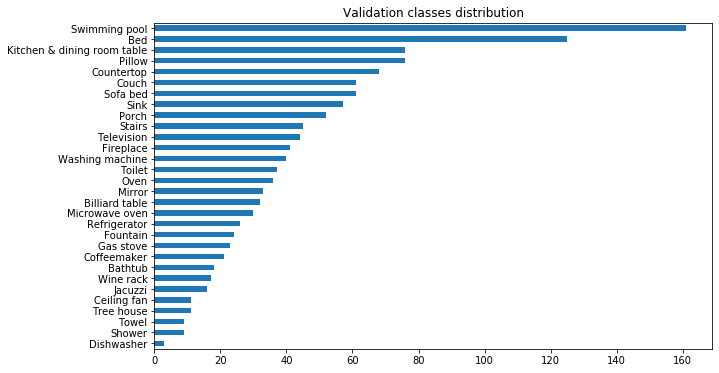

In [87]:
valid_annots.ClassName.value_counts().sort_values().plot(kind="barh", title="Validation classes distribution", figsize=(10, 6));

### Training distribution

In [82]:
train_annots = format_annotations(image_folder="train", 
                                  annotation_file="train-annotations-bbox.csv", 
                                  target_classes=subset)
train_annots.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
3454445,38bbd240e3dd6d2b,xclick,/m/03dnzn,1,0.00,0.997917,0.362500,0.998438,1,1,0,0,0,Bathtub,0
9051090,9a2f2850b2b6895e,xclick,/m/03dnzn,1,0.00,0.823750,0.382500,0.999167,1,1,0,0,0,Bathtub,0
6401293,6be60d5453217a0e,xclick,/m/03dnzn,1,0.00,0.999375,0.361163,0.917448,1,1,0,0,0,Bathtub,0
1158763,1123ab5e8d902bcb,xclick,/m/03dnzn,1,0.00,0.999375,0.391714,0.999058,1,1,0,0,0,Bathtub,0
533268,06e19a68abf5dde4,xclick,/m/03dnzn,1,0.24,0.630000,0.515625,0.930625,1,0,0,0,0,Bathtub,0


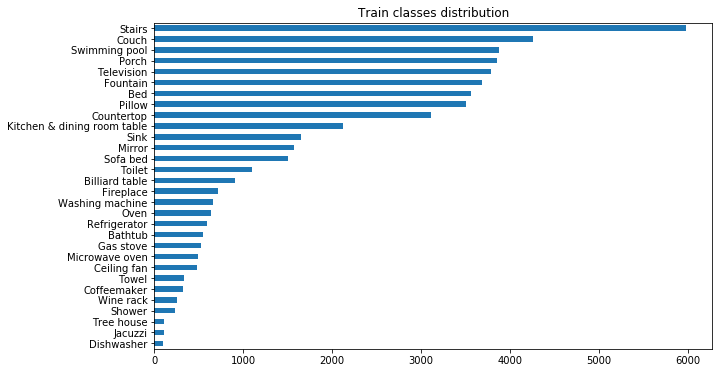

In [86]:
train_annots.ClassName.value_counts().sort_values().plot(kind="barh", title="Train classes distribution", figsize=(10, 6));

In [83]:
train_annots.ClassName.value_counts()

Stairs                         5981
Couch                          4259
Swimming pool                  3881
Porch                          3854
Television                     3789
Fountain                       3691
Bed                            3563
Pillow                         3508
Countertop                     3113
Kitchen & dining room table    2127
Sink                           1648
Mirror                         1572
Sofa bed                       1501
Toilet                         1099
Billiard table                  912
Fireplace                       711
Washing machine                 655
Oven                            637
Refrigerator                    592
Bathtub                         545
Gas stove                       526
Microwave oven                  485
Ceiling fan                     478
Towel                           338
Coffeemaker                     323
Wine rack                       254
Shower                          235
Tree house                  

### 10% of training data distribution

In [90]:
train_10_annots = format_annotations(image_folder="train_10", 
                                     annotation_file="train-annotations-bbox.csv", 
                                     target_classes=subset)
train_10_annots.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
1158763,1123ab5e8d902bcb,xclick,/m/03dnzn,1,0.000000,0.999375,0.391714,0.999058,1,1,0,0,0,Bathtub,0
11151925,bf1659a6948fd6f6,xclick,/m/03dnzn,1,0.139167,0.999167,0.344375,0.999375,1,1,0,0,0,Bathtub,0
10509875,b3da48968f56ccbe,xclick,/m/03dnzn,1,0.000000,0.999375,0.000000,0.999167,1,1,0,0,0,Bathtub,0
1270645,13067d0ea6ee89f8,xclick,/m/03dnzn,1,0.109375,0.999375,0.196813,0.999063,1,1,0,0,0,Bathtub,0
9310493,9ec96a976764024a,xclick,/m/03dnzn,1,0.000000,0.999375,0.446667,0.999167,1,1,0,0,0,Bathtub,0


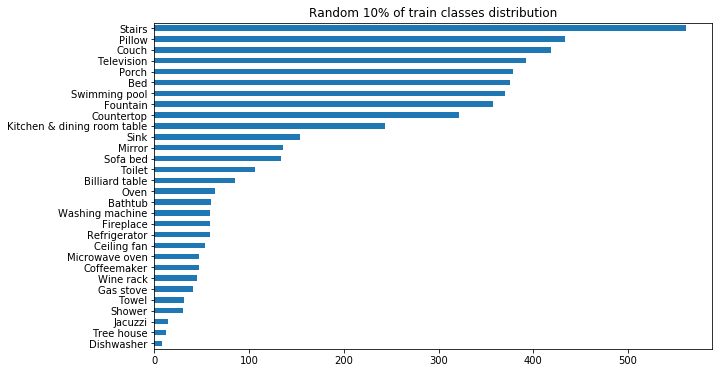

In [91]:
train_10_annots.ClassName.value_counts().sort_values().plot(kind="barh", title="Random 10% of train classes distribution", figsize=(10, 6));

In [94]:
train_10_annots.ClassName.value_counts()

Stairs                         561
Pillow                         433
Couch                          419
Television                     392
Porch                          379
Bed                            375
Swimming pool                  370
Fountain                       357
Countertop                     321
Kitchen & dining room table    243
Sink                           154
Mirror                         136
Sofa bed                       134
Toilet                         106
Billiard table                  85
Oven                            64
Bathtub                         60
Washing machine                 59
Fireplace                       59
Refrigerator                    59
Ceiling fan                     53
Microwave oven                  47
Coffeemaker                     47
Wine rack                       45
Gas stove                       41
Towel                           31
Shower                          30
Jacuzzi                         14
Tree house          

## Combine Test & Validation Labels

Since I'm using a data split called val_test (combination of validation and test labels), I need to combine them.

In [71]:
val_annotations = pd.read_csv("validation-annotations-bbox.csv")
test_annotations = pd.read_csv("test-annotations-bbox.csv")
val_annotations.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside
0,0001eeaf4aed83f9,xclick,/m/0cmf2,1,0.022673,0.964200,0.071038,0.800546,0,0,0,0,0
1,000595fe6fee6369,xclick,/m/02wbm,1,0.000000,1.000000,0.000000,1.000000,0,0,1,0,0
2,000595fe6fee6369,xclick,/m/02xwb,1,0.141384,0.179676,0.676275,0.731707,0,0,0,0,0
3,000595fe6fee6369,xclick,/m/02xwb,1,0.213549,0.253314,0.299335,0.354767,1,0,0,0,0
4,000595fe6fee6369,xclick,/m/02xwb,1,0.232695,0.288660,0.490022,0.545455,1,0,0,0,0


In [72]:
# Combine test & validation annotations into 1 file
val_test_annotations = val_annotations.append(test_annotations)
len(val_test_annotations), len(val_annotations) + len(test_annotations)

(929262, 929262)

In [73]:
# Save to CSV for later use
# val_test_annotations.to_csv("val-test-annotations.csv", index=False)

In [77]:
val_test_annots = format_annotations(image_folder="val_test",
                                     annotation_file="val-test-annotations.csv",
                                     target_classes=subset)
val_test_annots

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
788026,c4b1d21e32c98e4e,freeform,/m/03dnzn,1,0.011874,1.000000,0.328250,0.778549,0,0,0,0,0,Bathtub,0
752419,b512048868e6318e,freeform,/m/03dnzn,1,0.000303,0.999713,0.029815,0.999462,0,1,0,0,0,Bathtub,0
692361,9bbe5902409bfdca,freeform,/m/03dnzn,1,0.641643,1.000000,0.539640,1.000000,0,1,0,0,0,Bathtub,0
142263,789cc0283c0e18af,xclick,/m/03dnzn,1,0.039711,0.949458,0.119134,1.000000,0,0,0,0,0,Bathtub,0
501580,4c1649f8d5b677d3,freeform,/m/03dnzn,1,0.000000,0.984500,0.319811,0.999994,0,1,0,0,0,Bathtub,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117526,62fd8411facd03db,xclick,/m/0271qf7,1,0.047128,0.372607,0.000000,0.995575,0,1,1,0,0,Wine rack,29
117527,62fd8411facd03db,xclick,/m/0271qf7,1,0.374080,0.533137,0.632743,0.995575,0,0,1,0,0,Wine rack,29
204890,abe9ff8763cdcc5d,xclick,/m/0271qf7,1,0.000000,1.000000,0.000000,1.000000,0,0,0,0,0,Wine rack,29
190452,a0630cc0bccb0ff4,xclick,/m/0271qf7,1,0.000000,1.000000,0.000000,1.000000,0,1,0,0,0,Wine rack,29


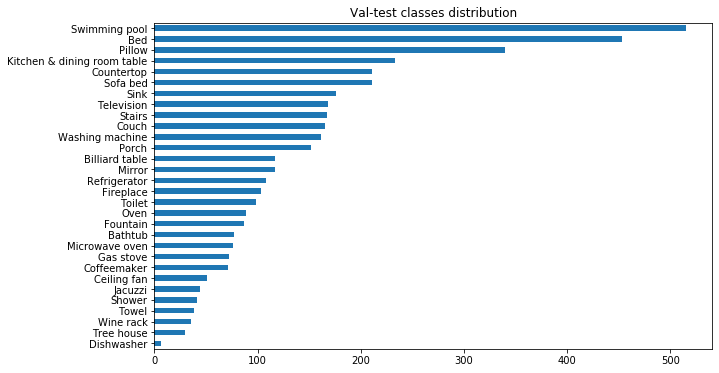

In [88]:
val_test_annots.ClassName.value_counts().sort_values().plot(kind="barh", title="Val-test classes distribution", figsize=(10, 6));

In [81]:
val_test_annots.ClassName.value_counts()

Swimming pool                  515
Bed                            453
Pillow                         340
Kitchen & dining room table    233
Countertop                     211
Sofa bed                       211
Sink                           176
Television                     168
Stairs                         167
Couch                          165
Washing machine                161
Porch                          152
Mirror                         117
Billiard table                 117
Refrigerator                   108
Fireplace                      103
Toilet                          98
Oven                            89
Fountain                        87
Bathtub                         77
Microwave oven                  76
Gas stove                       72
Coffeemaker                     71
Ceiling fan                     51
Jacuzzi                         44
Shower                          41
Towel                           38
Wine rack                       35
Tree house          

### 10% of val-test image distributions

In [96]:
val_test_10_annots = format_annotations(image_folder="val_test_10", 
                                        annotation_file="val-test-annotations.csv", 
                                        target_classes=subset)
val_test_10_annots.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,ClassName,ClassID
885954,ee29004d5e577594,freeform,/m/03dnzn,1,0.135073,0.778651,0.423828,0.846662,1,0,0,0,0,Bathtub,0
793987,c70036f949be0ffd,freeform,/m/03dnzn,1,0.000000,0.999994,0.000000,0.999977,0,0,0,0,0,Bathtub,0
325203,07b184134cd47d10,freeform,/m/03dnzn,1,0.000000,0.999703,0.285830,0.998991,0,1,0,0,0,Bathtub,0
893789,f1aca5ecf3cc9442,freeform,/m/03dnzn,1,0.001886,0.998743,0.001427,0.998285,1,1,0,0,0,Bathtub,0
790835,c5d4ebcdbff626e6,freeform,/m/03dnzn,1,0.330502,1.000000,0.417986,0.877806,0,0,0,0,0,Bathtub,0


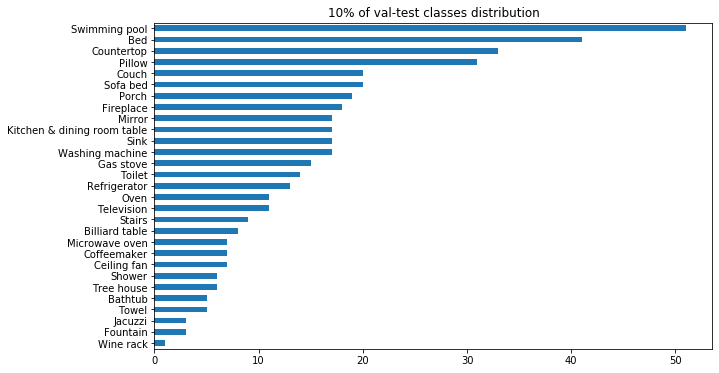

In [98]:
val_test_10_annots.ClassName.value_counts().sort_values().plot(kind="barh", title="10% of val-test classes distribution", figsize=(10, 6));

In [100]:
val_test_10_annots.ClassName.value_counts()

Swimming pool                  51
Bed                            41
Countertop                     33
Pillow                         31
Couch                          20
Sofa bed                       20
Porch                          19
Fireplace                      18
Mirror                         17
Kitchen & dining room table    17
Sink                           17
Washing machine                17
Gas stove                      15
Toilet                         14
Refrigerator                   13
Oven                           11
Television                     11
Stairs                          9
Billiard table                  8
Microwave oven                  7
Coffeemaker                     7
Ceiling fan                     7
Shower                          6
Tree house                      6
Bathtub                         5
Towel                           5
Fountain                        3
Jacuzzi                         3
Wine rack                       1
Name: ClassNam

## TODO - Create labels and CSV's of images/image splits 